# Multilevel Gravity Survey with MLDA

### Gravity Surveying
In this example, we solve a 2-dimensional gravity surveying problem, adapted from the 1D problem presented in Hansen (2010). 

Our aim is to recover a two-dimensional mass distribution $f(\vec{t})$ at a known depth $d$ below the surface from measurements $g(\vec{s})$ of the vertical component of the gravitational field at the surface. The contribution to $g(\vec{s})$ from infinitesimally small areas of the subsurface mass distribution are given by:

\begin{equation}
    dg = \frac{\sin \theta}{r^2} f(\vec{t}) \: d\vec{t}
\end{equation}
where $\theta$ is the angle between the vertical plane and a straight line between two points $f(\vec{t})$ and $g(\vec{s})$, and $r = | \vec{s} - \vec{t} |$ is the Eucledian distance between the points. We exploit that $\sin \theta = \frac{d}{r}$, so that

\begin{equation}
    \frac{\sin \theta}{r^2} f(\vec{t}) \: d\vec{t} = \frac{d}{r^3} f(\vec{t}) \: d\vec{t} = \frac{d}{ | \vec{s} - \vec{t} |^3} f(\vec{t}) \: d\vec{t}
\end{equation}

This yields the integral equation,

\begin{equation}
    g(\vec{s}) = \iint_T \frac{d}{ | \vec{s} - \vec{t} |^3} f(\vec{t}) \: d\vec{t}
\end{equation}

where $T = [0,1]^2$ is the domain of the function $f(\vec{t})$. This constitutes our forward model.

We solve this integral numerically using midpoint quadrature. For simplicity, we use the same number of quadrature points along each axis, so that in discrete form our forward model becomes

\begin{equation}
    g(\vec{s}_i) = \sum_{j=1}^{m} \omega_j \frac{d}{ | \vec{s}_i - \vec{t}_j |^3} \hat{f}(\vec{t}_j), \quad i = 1, \dots, n, \quad j = 1, \dots, m
\end{equation}

where $\omega_j = \frac{1}{m}$ are quadrature weights, $\hat{f}(\vec{t}_j)$ is the approximate subsurface mass at quadrature points $j = 1, \dots, m$, and  $g(\vec{s}_i)$ is surface measurements at collocation points $i = 1, \dots, n$. Hence when $n > m$, we are dealing with an overdetermined problem and vice versa. 

This results in a linear system $\mathbf{Ax = b}$, where
\begin{equation}
    a_{ij} = \omega_j \frac{d}{ | \vec{s}_i - \vec{t}_j |^3}, \quad x_j = \hat{f}(\vec{t}_j), \quad b_i = g(\vec{s}_i).
\end{equation}
In this particular problem, the matrix $\mathbf{A}$ has a very high condition number, leading to an ill-posed inverse problem, which entails numerical instability and spurious, often oscillatory, solutions for noisy right hand sides. These types of problems are traditionally solved by way of some manner of *regularisation*, but they can be handled in a natural and elegant fashion in the context of a Bayesian inverse problem.

### Mass Distribution as a Gaussian Random Process
We model the unknown mass distribution as a Gaussian Random Process with a Matern 5/2 covariance kernel (Rasmussen and Williams, 2006):
\begin{equation}
    C_{5/2}(\vec{t}, \vec{t}') = \sigma^2 \left( 1 + \frac{\sqrt{5} | \vec{t}-\vec{t}' | }{l} + \frac{5 | \vec{t}-\vec{t}' |^2}{3l^2} \right) \exp \left( - \frac{\sqrt{5} | \vec{t}-\vec{t}' | }{l} \right)
\end{equation}
where $l$ is the covariance length scale and $\sigma^2$ is the variance.

### References
Per Christian Hansen. *Discrete Inverse Problems: Insight and Algorithms*. Society for Industrial and Applied Mathematics, January 2010.

Carl Edward Rasmussen and Christopher K. I. Williams. *Gaussian processes for machine learning*. Adaptive computation and machine learning. 2006.

In [1]:
# Set the path to the modules holding random field class
import sys
sys.path.insert(1, 'mlda/')

In [2]:
# Restrict BLAS to operate on a single thread at a time,
# since multithreading doesn't play well with multiple parallel chains
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [3]:
# Import time for benchmarking
import time

# Get the essentials
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Get Matern52 kernel for modelling Gaussian Random Field
from RandomProcess import Matern52

# Get interpolator for projecting eigenmodes between model levels.
from scipy.spatial import distance_matrix
from scipy.interpolate import RectBivariateSpline

# Get the good stuff.
import pymc3 as pm

import theano
import theano.tensor as tt

In [4]:
# Just checking.
print('Theano version: {}'.format(theano.__version__))
print('PyMC3 version: {}'.format(pm.__version__))

Theano version: 1.0.5
PyMC3 version: 3.9.3


In [5]:
class Gravity:
    '''
    Gravity is a class that implements a simple gravity surveying problem,
    as described in Hansen, P. C. (2010). Discrete Inverse Problems: Insight and Algorithms. 
    Society for Industrial and Applied Mathematics.
    It uses midpoint quadrature to evaluate a Fredholm integral of the first kind.
    '''
    
    def __init__(self, f_function, depth, n_quad, n_data):
        
        # Set the function describing the distribution of subsurface density.
        self.f_function = f_function
        
        # Set the depth of the density (distance to the surface measurements).
        self.depth = depth
        
        # Set the quadrature degree along one dimension.
        self.n_quad = n_quad;
        
        # Set the number of data points along one dimension
        self.n_data = n_data
        
        # Set the quadrature points.
        x = np.linspace(0, 1, self.n_quad+1); self.tx = (x[1:] + x[:-1]) / 2
        y = np.linspace(0, 1, self.n_quad+1); self.ty = (y[1:] + y[:-1]) / 2
        TX, TY = np.meshgrid(self.tx, self.ty)
        
        # Set the measurement points.
        self.sx = np.linspace(0, 1, self.n_data)
        self.sy = np.linspace(0, 1, self.n_data)
        SX, SY = np.meshgrid(self.sx, self.sy)
        
        # Create coordinate vectors.
        self.T_coords = np.c_[TX.ravel(), TY.ravel(), np.zeros(self.n_quad**2)]
        self.S_coords = np.c_[SX.ravel(), SY.ravel(), self.depth*np.ones(self.n_data**2)]
        
        # Set the quadrature weights.
        self.w = 1/self.n_quad**2
        
        # Compute a distance matrix
        dist = distance_matrix(self.S_coords, self.T_coords)
        
        # Create the Fremholm kernel.
        self.K = self.w * self.depth/dist**3
        
        # Evaluate the density function on the quadrature points.
        self.f = self.f_function(TX, TY).flatten()
        
        # Compute the surface density (noiseless measurements)
        self.g = np.dot(self.K, self.f)
    
    def plot_model(self):
        
        # Plot the density and the signal.
        fig, axes = plt.subplots(1,2, figsize=(16,6))
        axes[0].set_title('Density')
        f = axes[0].imshow(self.f.reshape(self.n_quad, self.n_quad), extent=(0,1,0,1), origin='lower', cmap='plasma')
        fig.colorbar(f, ax=axes[0])
        axes[1].set_title('Signal')
        g = axes[1].imshow(self.g.reshape(self.n_data, self.n_data), extent=(0,1,0,1), origin='lower', cmap='plasma')
        fig.colorbar(g, ax=axes[1])
        plt.show()
        
    def plot_kernel(self):
        
        # Plot the kernel.
        plt.figure(figsize=(8,6))
        plt.imshow(self.K, cmap='plasma'); plt.colorbar()
        plt.show()

In [6]:
# This is the function, describing the subsurface density.
def f(TX, TY):
    f = np.sin(np.pi*TX) + np.sin(5*np.pi*TX) + np.sin(3*np.pi*TY) + TY + 1
    #f = np.sin(np.pi*TX) + np.sin(np.pi*TY)
    f = f/f.max()
    return f

In [7]:
# Set the model parameters.
depth = 0.1
n_quad = 64
n_data = 64

# Initialise a model
model_true = Gravity(f, depth, n_quad, n_data)

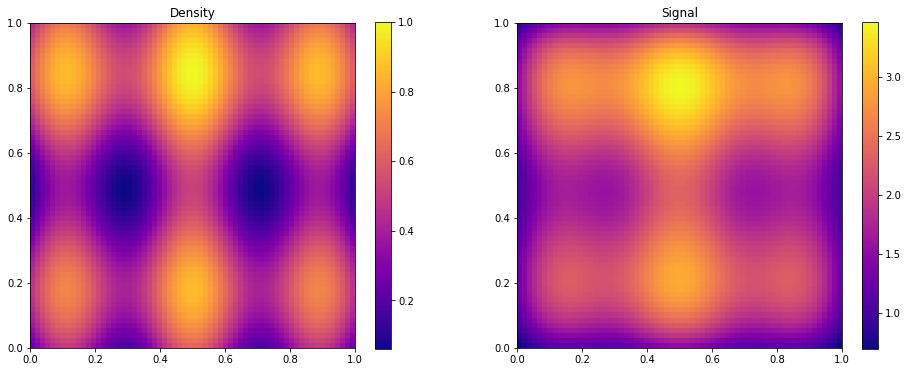

In [8]:
model_true.plot_model()

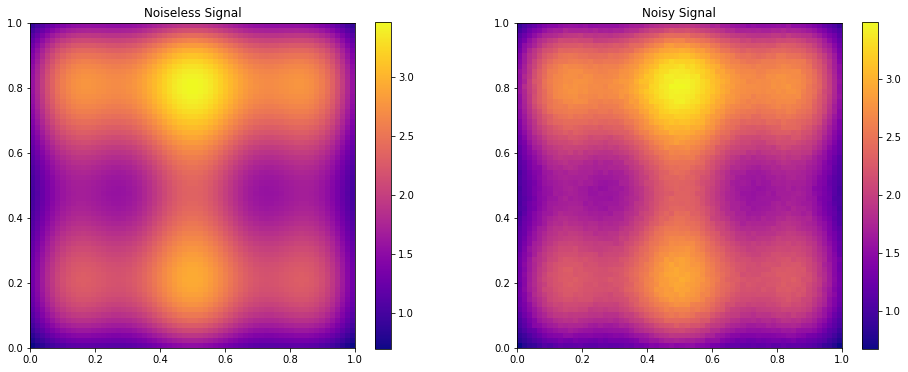

In [9]:
# Add noise to the data.
noise_level = 0.02
np.random.seed(123)
noise = np.random.normal(0, noise_level, n_data**2)
data = model_true.g + noise

# Plot the density and the signal.
fig, axes = plt.subplots(1,2, figsize=(16,6))
axes[0].set_title('Noiseless Signal')
g = axes[0].imshow(model_true.g.reshape(n_data, n_data), extent=(0,1,0,1), origin='lower', cmap='plasma')
fig.colorbar(g, ax=axes[0])
axes[1].set_title('Noisy Signal')
d = axes[1].imshow(data.reshape(n_data, n_data), extent=(0,1,0,1), origin='lower', cmap='plasma')
fig.colorbar(d, ax=axes[1])
plt.show()

In [10]:
class Gravity_Forward(Gravity):
    '''
    Gravity forward is a class that implements the gravity problem,
    but computation of signal and density is delayed to the "solve"
    method, since it relied on a Gaussian Random Field to model
    the (unknown) density.
    '''
    def __init__(self, depth, n_quad, n_data):
        
        # Set the depth of the density (distance to the surface measurements).
        self.depth = depth
        
        # Set the quadrature degree along one axis.
        self.n_quad = n_quad;
        
        # Set the number of data points along one axis.
        self.n_data = n_data
        
        # Set the quadrature points.
        x = np.linspace(0, 1, self.n_quad+1); self.tx = (x[1:] + x[:-1]) / 2
        y = np.linspace(0, 1, self.n_quad+1); self.ty = (y[1:] + y[:-1]) / 2
        TX, TY = np.meshgrid(self.tx, self.ty)
        
        # Set the measurement points.
        self.sx = np.linspace(0, 1, self.n_data)
        self.sy = np.linspace(0, 1, self.n_data)
        SX, SY = np.meshgrid(self.sx, self.sy)
        
        # Create coordinate vectors.
        self.T_coords = np.c_[TX.ravel(), TY.ravel(), np.zeros(self.n_quad**2)]
        self.S_coords = np.c_[SX.ravel(), SY.ravel(), self.depth*np.ones(self.n_data**2)]
        
        # Set the quadrature weights.
        self.w = 1/self.n_quad**2
        
        # Compute a distance matrix
        dist = distance_matrix(self.S_coords, self.T_coords)
        
        # Create the Fremholm kernel.
        self.K = self.w * self.depth/dist**3
        
    def set_random_process(self, random_process, lamb, mkl):
        
        # Set the number of KL modes.
        self.mkl = mkl
        
        # Initialise a random process on the quadrature points.
        # and compute the eigenpairs of the covariance matrix,
        self.random_process = random_process(self.T_coords, self.mkl, lamb)
        self.random_process.compute_eigenpairs()
    
    def solve(self, parameters):
        
        # Internalise the Random Field parameters
        self.parameters = parameters
        
        # Create a realisation of the random process, given the parameters.
        self.random_process.generate(self.parameters)
        mean = 0.0; stdev = 1.0;
        
        # Set the density.
        self.f = mean + stdev*self.random_process.random_field
        
        # Compute the signal.
        self.g = np.dot(self.K, self.f)
        
    def get_data(self):
        
        # Get the data vector.
        return self.g

In [11]:
# We project the eigenmodes of the fine model to the quadrature points
# of the coarse model using linear interpolation.
def project_eigenmodes(model_coarse, model_fine):
    model_coarse.random_process.eigenvalues = model_fine.random_process.eigenvalues 
    for i in range(model_coarse.mkl):
        interpolator = RectBivariateSpline(model_fine.tx, model_fine.ty, model_fine.random_process.eigenvectors[:,i].reshape(model_fine.n_quad, model_fine.n_quad))
        model_coarse.random_process.eigenvectors[:,i] = interpolator(model_coarse.tx, model_coarse.ty).ravel()

Level 0:


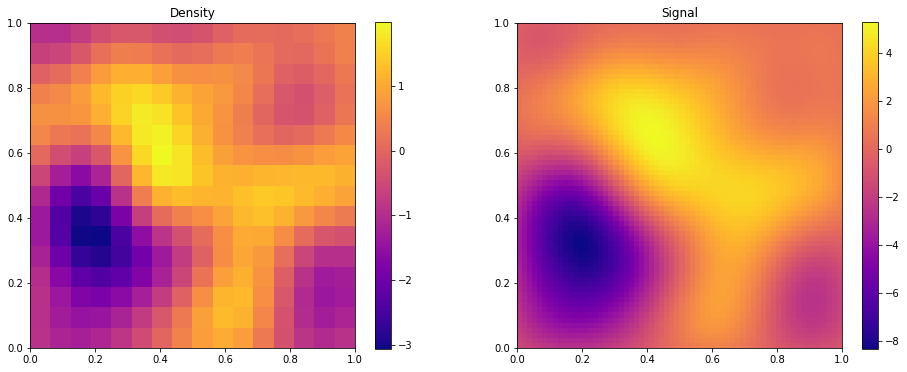

Level 1:


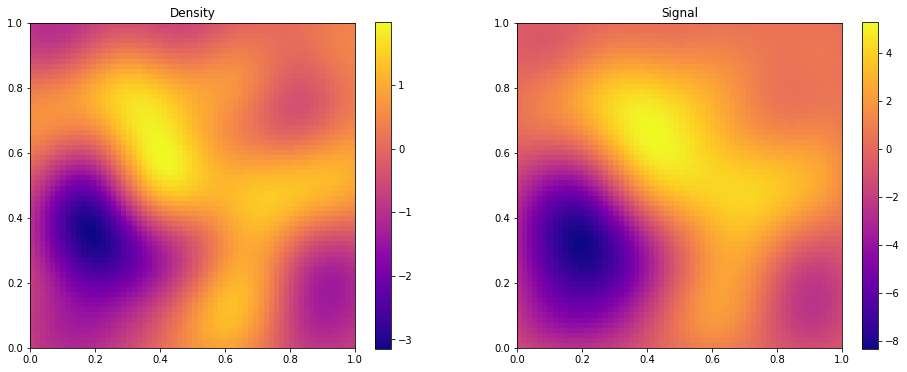

In [12]:
# Set random process parameters.
lamb = 0.15
mkl = 32

# Set the quadrature degree for each model level (coarsest first)
n_quadrature = [16, 64]

# Initialise the models, according the quadrature degree.
my_models = []
for i, n_quad in enumerate(n_quadrature):
     my_models.append(Gravity_Forward(depth, n_quad, n_data))
     my_models[i].set_random_process(Matern52, lamb, mkl)
    
# Project the eigenmodes of the fine model to the coarse model.
for m in my_models[:-1]:
    project_eigenmodes(m, my_models[-1])

# Plot the same random realisation for each level, and the corresponding signal,
# to validate that the levels are equivalents.
for i, m in enumerate(my_models):
    print('Level {}:'.format(i))
    np.random.seed(2)
    m.solve(np.random.normal(size=mkl))
    m.plot_model()

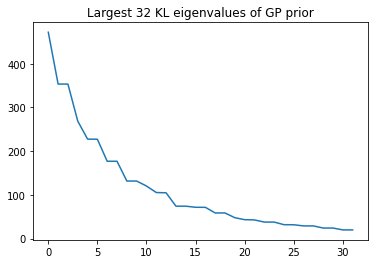

In [13]:
plt.title('Largest {} KL eigenvalues of GP prior'.format(mkl))
plt.plot(my_models[-1].random_process.eigenvalues)
plt.show()

In [14]:
%%timeit
my_models[0].solve(np.random.normal(size=mkl))

895 µs ± 52.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%%timeit
my_models[-1].solve(np.random.normal(size=mkl))

8.72 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
# Number of draws from the distribution
ndraws = 10000

# Number of burn-in samples
nburn = 2000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 1000000 # Set high to prevent tuning.
discard_tuning = True
scaling = 0.01

# Number of independent chains. 
# Set the number of KL modes to accomodate the minimum requirement of the DEM sampler.
nchains = 4

# Subsampling rate for MLDA
nsub = 10

# Do blocked/compounds sampling in Metropolis and MLDA 
# Note: This choice applies only to the coarsest level in MLDA 
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = True

# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros(mkl)
cov_prior = np.eye(mkl)

# Set the sigma for inference.
sigma = 1.0

# Data generation seed
data_seed = 1234

# Sampling seed
sampling_seed = 1234

In [17]:
def my_loglik(my_model, theta, data, sigma):
    """
    This returns the log-likelihood of my_model given theta,
    datapoints, the observed data and sigma. It uses the
    model_wrapper function to do a model solve.
    """
    my_model.solve(theta)
    output = my_model.get_data()
    return - (0.5 / sigma ** 2) * np.sum((output - data) ** 2)

class LogLike(tt.Op):
    """
    Theano Op that wraps the log-likelihood computation, necessary to
    pass "black-box" fenics code into pymc3.
    Based on the work in:
    https://docs.pymc.io/notebooks/blackbox_external_likelihood.html
    https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html
    """

    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model and a model object) and returning a single "scalar"
    # value (the log-likelihood)
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, data, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        my_model:
            A Model object (defined in model.py) that contains the parameters
            and functions of out model.
        loglike:
            The log-likelihood function we've defined, in this example it is
            my_loglik.
        data:
            The "observed" data that our log-likelihood function takes in. These
            are the true data generated by the finest model in this example.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.
        sigma:
            The noise standard deviation that our function requires.
        """
        # add inputs as class attributes
        self.my_model = my_model
        self.likelihood = loglike
        self.data = data
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(self.my_model, theta, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

In [18]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logl = []
for i, m_i in enumerate(my_models):
    logl.append(LogLike(m_i, my_loglik, data, sigma))

In [19]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        
        # Multivariate normal prior.
        theta = pm.MvNormal('theta', mu=mu_prior, cov=cov_prior, shape=mkl)
        #theta = pm.Uniform('theta', upper=3, lower=-3, shape=mkl)
        
        # Use the Potential class to evaluate likelihood (DensityDist appears to be broken)
        pm.Potential('likelihood', logl[j](theta))
        
    coarse_models.append(model)

In [20]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.
method_names = []
traces = []
runtimes = []

with pm.Model() as model:
    
    # Multivariate normal prior.
    theta = pm.MvNormal('theta', mu=mu_prior, cov=cov_prior, shape=mkl)
    
    # Use the Potential class to evaluate likelihood (DensityDist appears to be broken)
    pm.Potential('likelihood', logl[-1](theta))
    
    # Find the MAP estimate for convergence diagnostics. 
    # It is NOT used as starting point for sampling.
    MAP = pm.find_MAP()
    
    #MAP_pert = {'theta': MAP['theta'] + np.random.normal(0,0.1,size=mkl)}
    
    # Initialise an MLDA step method object, passing the subsampling rate and
    # coarse models list
    # Also initialise a Metropolis step method object
    step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval, blocked=blocked, scaling=scaling)
    step_mlda = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
                        tune=tune, base_tune_interval=tune_interval, base_blocked=blocked,
                        base_sampler='Metropolis', base_scaling=scaling)
    
    # Inference!
    # Metropolis
    t_start = time.time()
    method_names.append("Metropolis")
    traces.append(pm.sample(draws=ndraws, step=step_metropolis,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)
    
    # MLDA-Metropolis
    t_start = time.time()
    method_names.append("MLDA-Metropolis")
    traces.append(pm.sample(draws=ndraws, step=step_mlda,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)

/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/pymc3/step_methods/metropolis.py:989: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 382 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
MLDA: [theta]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 1006 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
# Print MAP estimate and pymc3 sampling summary
# I put this (and the following diagnostics) in the pm.Model() context 
# to suppress the (many) deprecation warnings.
with model:
    print(f"\nDetailed summaries and plots:\nMAP estimate: {MAP['theta']}. Not used as starting point.")
    for i, trace in enumerate(traces):
        print(f"\n{method_names[i]} Sampler:\n") 
        display(pm.stats.summary(trace))


Detailed summaries and plots:
MAP estimate: [-1.33402118e+00  1.24345121e-01 -1.32829997e-01  2.72310841e-04
  9.96464078e-01 -4.51202937e-01  4.94821709e-02 -4.45663342e-02
  8.38193548e-02  6.41036823e-02 -3.44493553e-01  1.57026089e-04
  1.37496327e-03 -2.68908538e-02 -3.03662766e-02 -6.65569118e-01
  7.53399040e-01  2.81476079e-02  3.42299650e-02  8.67310299e-04
  3.21731586e-01  3.90095240e-01  4.87326383e-02  5.90310005e-02
  1.00667458e-03  2.06568823e-04  2.88691040e-02 -7.40965703e-03
 -7.70569427e-03  2.24167486e-02  5.66651982e-01 -6.06797202e-01]. Not used as starting point.

Metropolis Sampler:



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],-1.334,0.010,-1.353,-1.315,0.000,0.000,3269.0,3267.0,3268.0,5508.0,1.00
theta[1],0.125,0.015,0.096,0.153,0.000,0.000,1629.0,1629.0,1632.0,3048.0,1.01
theta[2],-0.132,0.015,-0.161,-0.104,0.000,0.000,1487.0,1487.0,1485.0,2923.0,1.00
theta[3],-0.000,0.021,-0.040,0.039,0.001,0.001,798.0,798.0,796.0,1464.0,1.01
theta[4],0.997,0.024,0.951,1.041,0.001,0.001,622.0,622.0,624.0,1166.0,1.01
theta[5],-0.451,0.025,-0.499,-0.406,0.001,0.001,674.0,674.0,673.0,1281.0,1.00
theta[6],0.053,0.033,-0.010,0.113,0.002,0.001,421.0,421.0,422.0,857.0,1.01
theta[7],-0.047,0.031,-0.105,0.012,0.002,0.001,308.0,308.0,310.0,904.0,1.01
theta[8],0.078,0.044,-0.009,0.161,0.003,0.002,228.0,228.0,228.0,472.0,1.01
theta[9],0.064,0.044,-0.020,0.144,0.004,0.003,132.0,132.0,132.0,296.0,1.06



MLDA-Metropolis Sampler:



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],-1.334,0.010,-1.353,-1.314,0.000,0.000,12700.0,12653.0,12818.0,11068.0,1.00
theta[1],0.124,0.015,0.095,0.152,0.000,0.000,9599.0,9599.0,9591.0,15225.0,1.00
theta[2],-0.133,0.015,-0.162,-0.105,0.000,0.000,10230.0,10230.0,10234.0,15639.0,1.00
theta[3],-0.000,0.021,-0.040,0.039,0.000,0.000,5191.0,5191.0,5196.0,9060.0,1.00
theta[4],0.997,0.025,0.952,1.044,0.000,0.000,3658.0,3642.0,3658.0,6175.0,1.00
theta[5],-0.452,0.025,-0.498,-0.405,0.000,0.000,4084.0,4084.0,4083.0,7560.0,1.00
theta[6],0.051,0.032,-0.009,0.114,0.001,0.000,2583.0,2583.0,2582.0,5093.0,1.00
theta[7],-0.044,0.032,-0.101,0.020,0.001,0.000,2736.0,2736.0,2740.0,5113.0,1.00
theta[8],0.083,0.044,-0.000,0.166,0.001,0.001,1398.0,1398.0,1399.0,2846.0,1.01
theta[9],0.061,0.043,-0.019,0.143,0.001,0.001,1383.0,1383.0,1383.0,3169.0,1.01



Metropolis Sampler: 10000 drawn samples in each of 4 chains.
Runtime: 383.39991569519043 seconds
Acceptance rate: 0.421025
ESS list: [3267.503 1631.815 1484.942  796.159  624.187  673.291  422.124  309.95
  228.486  131.617  191.115  139.384  136.779   80.566   96.777   43.171
   59.974   23.66    37.549   17.563   36.274   27.014   11.109   12.576
   35.541   12.081    7.513   13.036    7.854    6.537    6.742   14.601]
Normalised ESS list: [0.082 0.041 0.037 0.02  0.016 0.017 0.011 0.008 0.006 0.003 0.005 0.003
 0.003 0.002 0.002 0.001 0.001 0.001 0.001 0.    0.001 0.001 0.    0.
 0.001 0.    0.    0.    0.    0.    0.    0.   ]
ESS/sec: [8.522 4.256 3.873 2.077 1.628 1.756 1.101 0.808 0.596 0.343 0.498 0.364
 0.357 0.21  0.252 0.113 0.156 0.062 0.098 0.046 0.095 0.07  0.029 0.033
 0.093 0.032 0.02  0.034 0.02  0.017 0.018 0.038]

MLDA-Metropolis Sampler: 10000 drawn samples in each of 4 chains.
Runtime: 1007.1082150936127 seconds
Acceptance rate: 0.7718
ESS list: [12818.399  9590.9

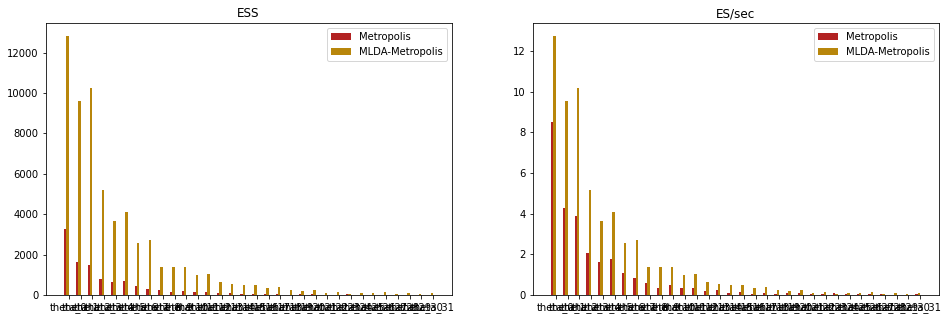

In [22]:
acc = []
ess = []
ess_n = []
performances = []

# Get some more statistics.
with model:
    for i, trace in enumerate(traces):
        acc.append(trace.get_sampler_stats('accepted').mean())
        ess.append(np.array(pm.ess(trace).to_array()))
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
        print(f'\n{method_names[i]} Sampler: {len(trace)} drawn samples in each of '
              f'{trace.nchains} chains.'
              f'\nRuntime: {runtimes[i]} seconds'
              f'\nAcceptance rate: {acc[i]}'
              f'\nESS list: {np.round(ess[i][0], 3)}'
              f'\nNormalised ESS list: {np.round(ess_n[i][0], 3)}'
              f'\nESS/sec: {np.round(performances[i][0], 3)}')
    
    # Plot the effective sample size (ESS) and relative ESS (ES/sec) of each of the sampling strategies.
    colors = ['firebrick', 'darkgoldenrod', 'darkcyan', 'olivedrab']
    
    fig, axes = plt.subplots(1,2, figsize=(16,5))
    
    axes[0].set_title('ESS')
    for i, e in enumerate(ess):
        axes[0].bar([j+i*0.2 for j in range(mkl)], e.ravel(), width=0.2, color=colors[i], label=method_names[i])
    axes[0].set_xticks([i+0.3 for i in range(mkl)]); axes[0].set_xticklabels(['theta_{}'.format(i) for i in range(mkl)])
    axes[0].legend()
    
    axes[1].set_title('ES/sec')
    for i, p in enumerate(performances):
        axes[1].bar([j+i*0.2 for j in range(mkl)], p.ravel(), width=0.2, color=colors[i], label=method_names[i])
    axes[1].set_xticks([i+0.3 for i in range(mkl)]); axes[1].set_xticklabels(['theta_{}'.format(i) for i in range(mkl)])
    axes[1].legend()
    plt.show()

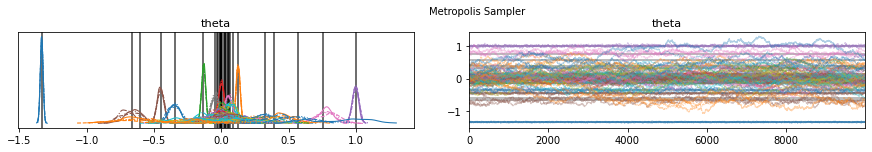

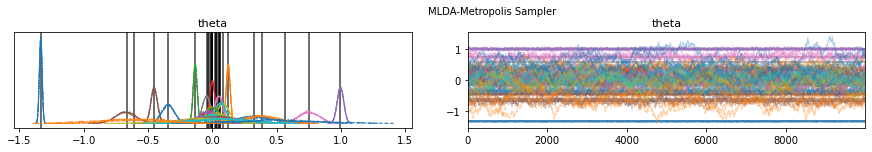

In [23]:
# Plot distributions and trace.
# Vertical grey lines represent the MAP estimate of each parameter.
with model:
    lines = (('theta',{}, MAP['theta'].tolist()),)
    for i, trace in enumerate(traces):
        pm.plots.traceplot(trace, lines=lines)
        
        # Ugly hack to get some titles in.
        x_offset = -0.1*ndraws
        y_offset = trace.get_values('theta').max() + 0.25*(trace.get_values('theta').max()-trace.get_values('theta').min())
        plt.text(x_offset, y_offset, '{} Sampler'.format(method_names[i]))

True Model


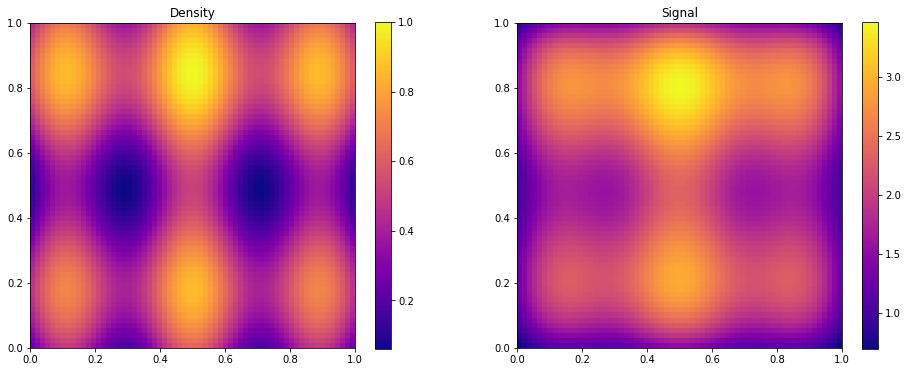

MAP estimate:


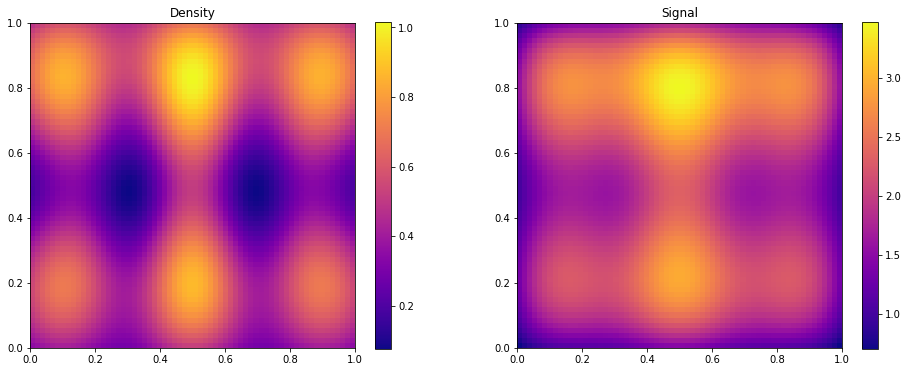

Recovered by: Metropolis


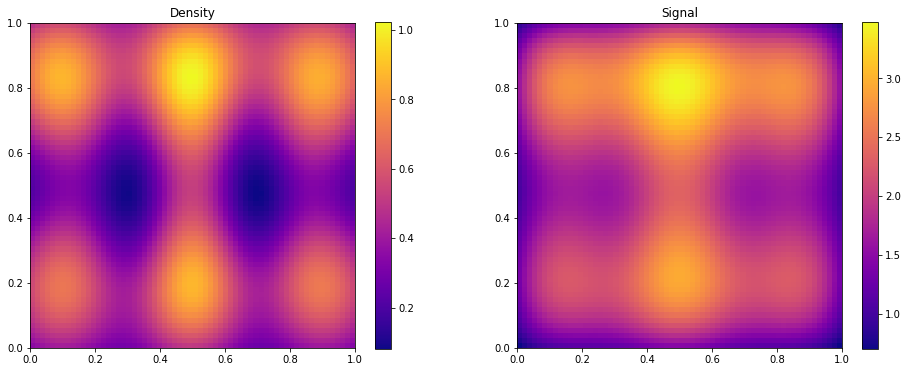

Recovered by: MLDA-Metropolis


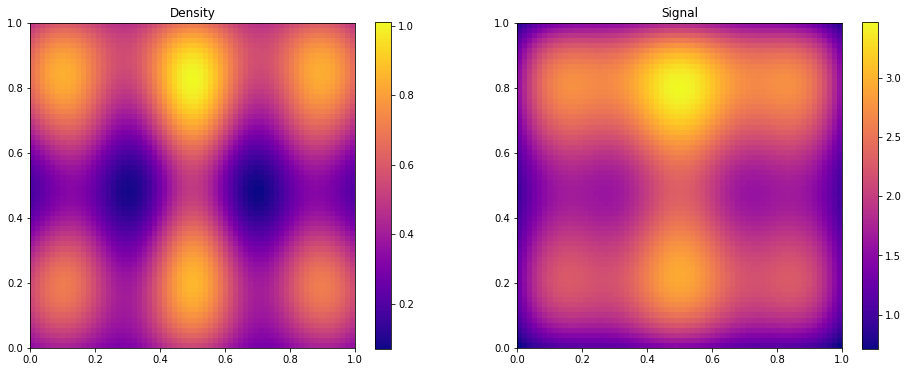

In [24]:
# Plot true and recovered densities
print('True Model')
model_true.plot_model()
with model:
    print('MAP estimate:')
    my_models[-1].solve(MAP['theta'])
    my_models[-1].plot_model()
    for i, t in enumerate(traces):
        print(f'Recovered by: {method_names[i]}')
        my_models[-1].solve(pm.stats.summary(t)['mean'].values)
        my_models[-1].plot_model()